# Demo 5 - K-Means Clustering in Spark
__`MIDS w261: Machine Learning at Scale | UC Berkeley School of Information | Spring 2019`__


By the end of this demo you should be able to:  
* ... __implement__ K-Means in Spark.
* ... __explain__ how the centroid initialization affects K-Means results & time to convergence.
* ... __explain__ how different join operations are implemented in Spark
* ... __explain__  the challenges of implementing the A Priori algorithm at Scale



### Notebook Set-Up

In [29]:
# imports
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
%reload_ext autoreload
%autoreload 2

In [30]:
# globals
HOME_DIR = "/media/notebooks" # this is where docker mounts your repo, ADJUST AS NEEDED
DEMO_DIR = HOME_DIR + "/LiveSessionMaterials/wk05Demo_Kmeans"


mkdir: `/user/root/demo4': File exists


# Content Review: Kmeans

K-Means clustering is an algorithm designed to group examples into K distinct groups based on their features. K-Means clustering can be used to categorize data when we do not have any concrete information about what those categories may look like. For example we may want to perform a market segmentation analysis on our customers but we don't actually know what the segments are.

At a high level clustering is an attempt to group objects in such a way as to make those objects similar to other objects within the group and dissimilar to those outside of the group. In order to perform K-Means clustering we want to minimize the distance between all of the examples that are a part of a cluster and the center of that cluster, also called the _cluster centroid_. The clustering algorithm solves the following cost minimization:

$$
\arg\min_{c} \sum_{i=1}^k\sum_{{x}\in c_i} \left\Vert {x}-\mu_i \right\Vert^2
$$

It turns out that the above minimization problem is very difficult to solve (t falls into the class of problems known as [NP-Hard](https://en.wikipedia.org/wiki/NP-hardness)). The K-Means algorithm attempts to solve this clustering problem iteratively by repeating the 2-step process of marking each example as belonging to a single cluster by finding the closest cluster centroid
and then adjusting each of the K cluster centroids so that each centroid is in the middle of all the examples that belong to that centroid.

[Here](http://stanford.edu/class/ee103/visualizations/kmeans/kmeans.html) is a simple visualization of the process. There are a number of up front choices that must be made before the algorithm can be implemented:

* __K__: the total number of centroids is selected using some apriori information about the desired outcome
* __Distance Function__: typically the euclidian distance is used but this can be any function $d({x}, \mu)$
* __Convergence Criteria__: a rule used to determine when the iterative process can stop.

The formal algorithm can then be defined as follows. First, decide the number of clusters $K$. Then:


| Step | Description | Pseudocode|        
| :---: |:---------------------------------------------: |:--------------- |
|1 |Initialize the center ('centroid') of the clusters| ${\mu}_i = $ random value $, i=1,...,k$|
|2|Attribute the closest cluster to each data point|${c}_i = \{j: d({x}_j, \mu_i) \le d({x}_j, \mu_l),  l \ne i, j=1,...,n\}$|
|3| Update centroid to the mean of points in that cluster|$\mu_i = \frac{1}{|c_i|}\sum_{j\in c_i} {x}_j,\forall i$|
|4|Repeat steps 2-3 until convergence criteria met||
||Notation:|${|c|} = $ number of elements in  ${c}$|

## Load Demo Data for K-means

The Iris dataset was used in R.A. Fisher's classic 1936 paper, [The Use of Multiple Measurements in Taxonomic Problems](http://rcs.chemometrics.ru/Tutorials/classification/Fisher.pdf). It includes three iris species with 50 samples each as well as some properties about each flower. One flower species is linearly separable from the other two, but the other two are not linearly separable from each other.

The columns in this dataset are:
> `Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species`

If you want to learn more about this dataset visit the [UCI Iris Data Set page](https://archive.ics.uci.edu/ml/datasets/iris). Use the cells below to download, preprocess and visualize this data set.

In [ ]:
# make data directory
!mkdir data

In [ ]:
# download the iris dataset
!curl -L -O https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data 

In [ ]:
# a few data cleaning steps... (remove blank last line, & separate features from labels)
!head -n -1 iris.data > data/iris_full.csv
!cut -d ',' -f 1-4 data/iris_full.csv > data/iris_features.csv
!rm iris.data

In [ ]:
# take a look at the first few lines
!head data/iris_full.csv

In [32]:
# set up constants for ease of directory use
IRIS_DATA_WITH_LABELS = DEMO_DIR + '/data/iris_full.csv'
IRIS_DATA = DEMO_DIR + '/data/iris_features.csv'


## Visualize Demo Data for Kmeans

For purposes of visualization of this dataset we use a PCA decomposition to project the 4 dimensional iris dataset down to 2 dimensions. This will give us the ability to roughly visualize the effectiveness of our K-Means clustering.

In [ ]:
# read in labeled data
mapping = {b'Iris-setosa': 0, 
           b'Iris-versicolor': 1, 
           b'Iris-virginica': 2}
names = mapping.keys()
data = np.loadtxt(IRIS_DATA_WITH_LABELS, delimiter=',', 
                  converters = {4: lambda s: mapping[s]})

In [ ]:
# custom plotting function
from utils import plot_iris_data
plot_iris_data(data[:,0:-1], data[:,-1], names, 'Iris Dataset (true labels)')

# K-Means in Python

## Implementation
A simple (non-scalable) implementation in Python. For this example we will use the Iris dataset without labels and a K of 3 since we know ahead of time there are 3 different species labels (setosa, versicolor, and virginica).

In [ ]:
import numpy as np

# read in the data from the IRIS_DATA file
samples = np.loadtxt(IRIS_DATA, 
                     delimiter=',')

# define the number of clusters
k = 3

# define the distance function as the normalized distance
def distance(a, b, ax=1):
    return np.linalg.norm(a - b, axis=ax)

def closestCluster(sample, centers):
    distances = distance(sample, centers)
    return np.argmin(distances)

# define the convergence criteria
convergenceCriteria = .001

# (step1) set the k initial clusters by assigning a random point
centroids = samples[np.random.choice(len(samples), size=k, replace=False)]

while True:
    # (step2) attribute the closest cluster to each point
    clusters = [closestCluster(sample, centroids) 
                for sample 
                in samples]
    
    # (step3) set the position of each cluster to the mean of all data points belonging to that cluster
    last_centroids = np.copy(centroids)
    for i in range(k):
        points = [samples[j] 
                  for j 
                  in range(len(samples)) if clusters[j] == i]
        centroids[i] = np.mean(points, axis=0)
    
    # (step4) repeat steps 2-3 until convergence criteria met
    error = distance(centroids, 
                     last_centroids, 
                     None)
    if error < convergenceCriteria:
        break

print('-------Final Centroids-------')
print(centroids)

## Results
Examine the results by assigning each of the datapoints in the file to the nearest cluster and then plot all of the samples along with their labels.

In [ ]:
labels = list(map(lambda sample: closestCluster(sample, centroids), samples))
plot_iris_data(np.array(samples), np.array(labels), ['cluster1', 'cluster2', 'cluster3'],
                'Iris Dataset (Python K-Means clustering)')

# K-Means in Spark

This is boilerplate code required for a notebook in this enviroment to create a local spark context.

In [12]:
from pyspark.sql import SparkSession

app_name = "week5_demo_acc"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

## Implementation
Compare this Spark K-Means implementation to the original, non-scalable implementation in Python. Structurally they are quite similar.

In [2]:
import numpy as np

lines = sc.textFile(IRIS_DATA)
samples = lines.map(lambda line: np.array([float(x) for x in line.split(',')])).cache()

# define the number of clusters
k = 3

# define the distance function as the normalized distance
def distance(a, b):
    return np.linalg.norm(a - b)

def closestCluster(p, centers):
    bestIndex = 0
    closest = float("+inf")
    for i in range(len(centers)):
        tempDist = distance(p, centers[i])
        if tempDist < closest:
            closest = tempDist
            bestIndex = i
    return bestIndex

# define the convergence criteria
convergenceCriteria = .001

# (step1) set the k initial clusters by assigning a random point
centroids = samples.takeSample(False, k, 1)

while True:
    # (step2) attribute the closest cluster to each point
    clusters = samples.map(lambda p: (closestCluster(p, centroids), (p, 1)))
    
    newpoints = clusters.reduceByKey(lambda p1_c1, p2_c2: (p1_c1[0] + p2_c2[0], p1_c1[1] + p2_c2[1])) \
                        .map(lambda st: (st[0], st[1][0] / st[1][1])) \
                        .collect()
    
    error = sum(np.sum(distance(centroids[iK], p)) for (iK, p) in newpoints)
        
    # (step3) set the position of each cluster to the mean of all data points belonging to that cluster
    for (iK, p) in newpoints:
        centroids[iK] = p
        
    # (step4) repeat steps 2-3 until convergence criteria met
    if error < convergenceCriteria:
        break
    
print('-------Final Centroids-------')
print(np.array(centroids))

NameError: name 'IRIS_DATA' is not defined

## Results
Examine the results by assigning each of the datapoints in the file to the nearest cluster and then plot all of the samples along with their labels.

In [ ]:
samples = np.loadtxt(IRIS_DATA, 
                     delimiter=',')
labels = list(map(lambda sample: closestCluster(sample, centroids), 
             samples))
plot_iris_data(np.array(samples), 
     np.array(labels), 
     ['cluster1', 'cluster2', 'cluster3'],
     'Iris Dataset (Spark K-Means clustering)')

Discussion

How does changing the centroid initialization affect the result?
How does changing the convergence criteria affect the result?

### See also:
* KMeans++
* KMeans||
* Canopy clustering

# Accumulators
Definitive Guide book, pg. 241

Accumulators are Spark's equivalent of Hadoop counters. Like broadcast variables they represent shared information across the nodes in your cluster, but unlike broadcast variables accumulators are _write-only_ ... in other words you can only access their values in the driver program and not on your executors (where transformations are applied). As convenient as this sounds, there are a few common pitfalls to avoid. Let's take a look.

Run the following cell to create a sample data file representing a list of `studentID, courseID, final_grade`...

In [9]:
%%writefile data/grades.csv
10001,101,98
10001,102,87
10002,101,75
10002,102,55
10002,103,80
10003,102,45
10003,103,75
10004,101,90
10005,101,85
10005,103,60

Overwriting data/grades.csv


Suppose we want to compute the average grade by course and student while also tracking the number of failing grades awarded. We might try something like this:

In [13]:
# function to increment the accumulator as we read in the data
def parse_grades(line, accumulator):
    """Helper function to parse input & track failing grades."""
    student,course,grade = line.split(',')
    grade = int(grade)
    if grade < 65:
        accumulator.add(1)
    return(student,course, grade)

In [14]:
# initialize an accumulator to track failing grades
nFailing = sc.accumulator(0)

In [21]:
# compute averages in spark
nFailing = sc.accumulator(0)
gradesRDD = sc.textFile('data/grades.csv')\
              .map(lambda x: parse_grades(x, nFailing))\
              .cache()


studentAvgs = gradesRDD.map(lambda x: (x[0], (x[2], 1)))\
                       .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))\
                       .mapValues(lambda x: x[0]/x[1])

courseAvgs = gradesRDD.map(lambda x: (x[1], (x[2], 1)))\
                      .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))\
                      .mapValues(lambda x: x[0]/x[1])

In [22]:
# take a look
print("===== average by student =====")
print(studentAvgs.collect())
print("===== average by course =====")
print(courseAvgs.collect())
print("===== number of failing grades awarded =====")
print(nFailing)

===== average by student =====
[('10001', 92.5), ('10004', 90.0), ('10002', 70.0), ('10003', 60.0), ('10005', 72.5)]
===== average by course =====
[('102', 62.333333333333336), ('101', 87.0), ('103', 71.66666666666667)]
===== number of failing grades awarded =====
3


> __DISCUSSION QUESTIONS:__
* What is wrong with the results? (__`HINT:`__ _how many failing grades are there really?_)
* Why might this be happening? (__`HINT:`__ _How many actions are there in this code? Which parts of the DAG are recomputed for each of these actions?_)
* What one line could we add to the code to fix this problem?
  * What could go wrong with our "fix"?
* How could we have designed our parser differently to avoid this problem in the first place?

## Custom Accumulators
https://spark.apache.org/docs/latest/rdd-programming-guide.html#accumulators

While SparkContext supports accumulators for primitive data types like int and float, users can also define accumulators for custom types by providing a custom AccumulatorParam object. 

We may want to utilize custom accumulators later in the course when we implement PageRank, or Shortest Path (graph) algorithms

In [26]:
from pyspark.accumulators import AccumulatorParam

# Spark only implements Accumulator parameter for numeric types.
# This class extends Accumulator support to the string type.
class StringAccumulatorParam(AccumulatorParam):
    def zero(self, value):
        return value
    def addInPlace(self, val1, val2):
        return val1 +" -> "+ val2

# Aggregations

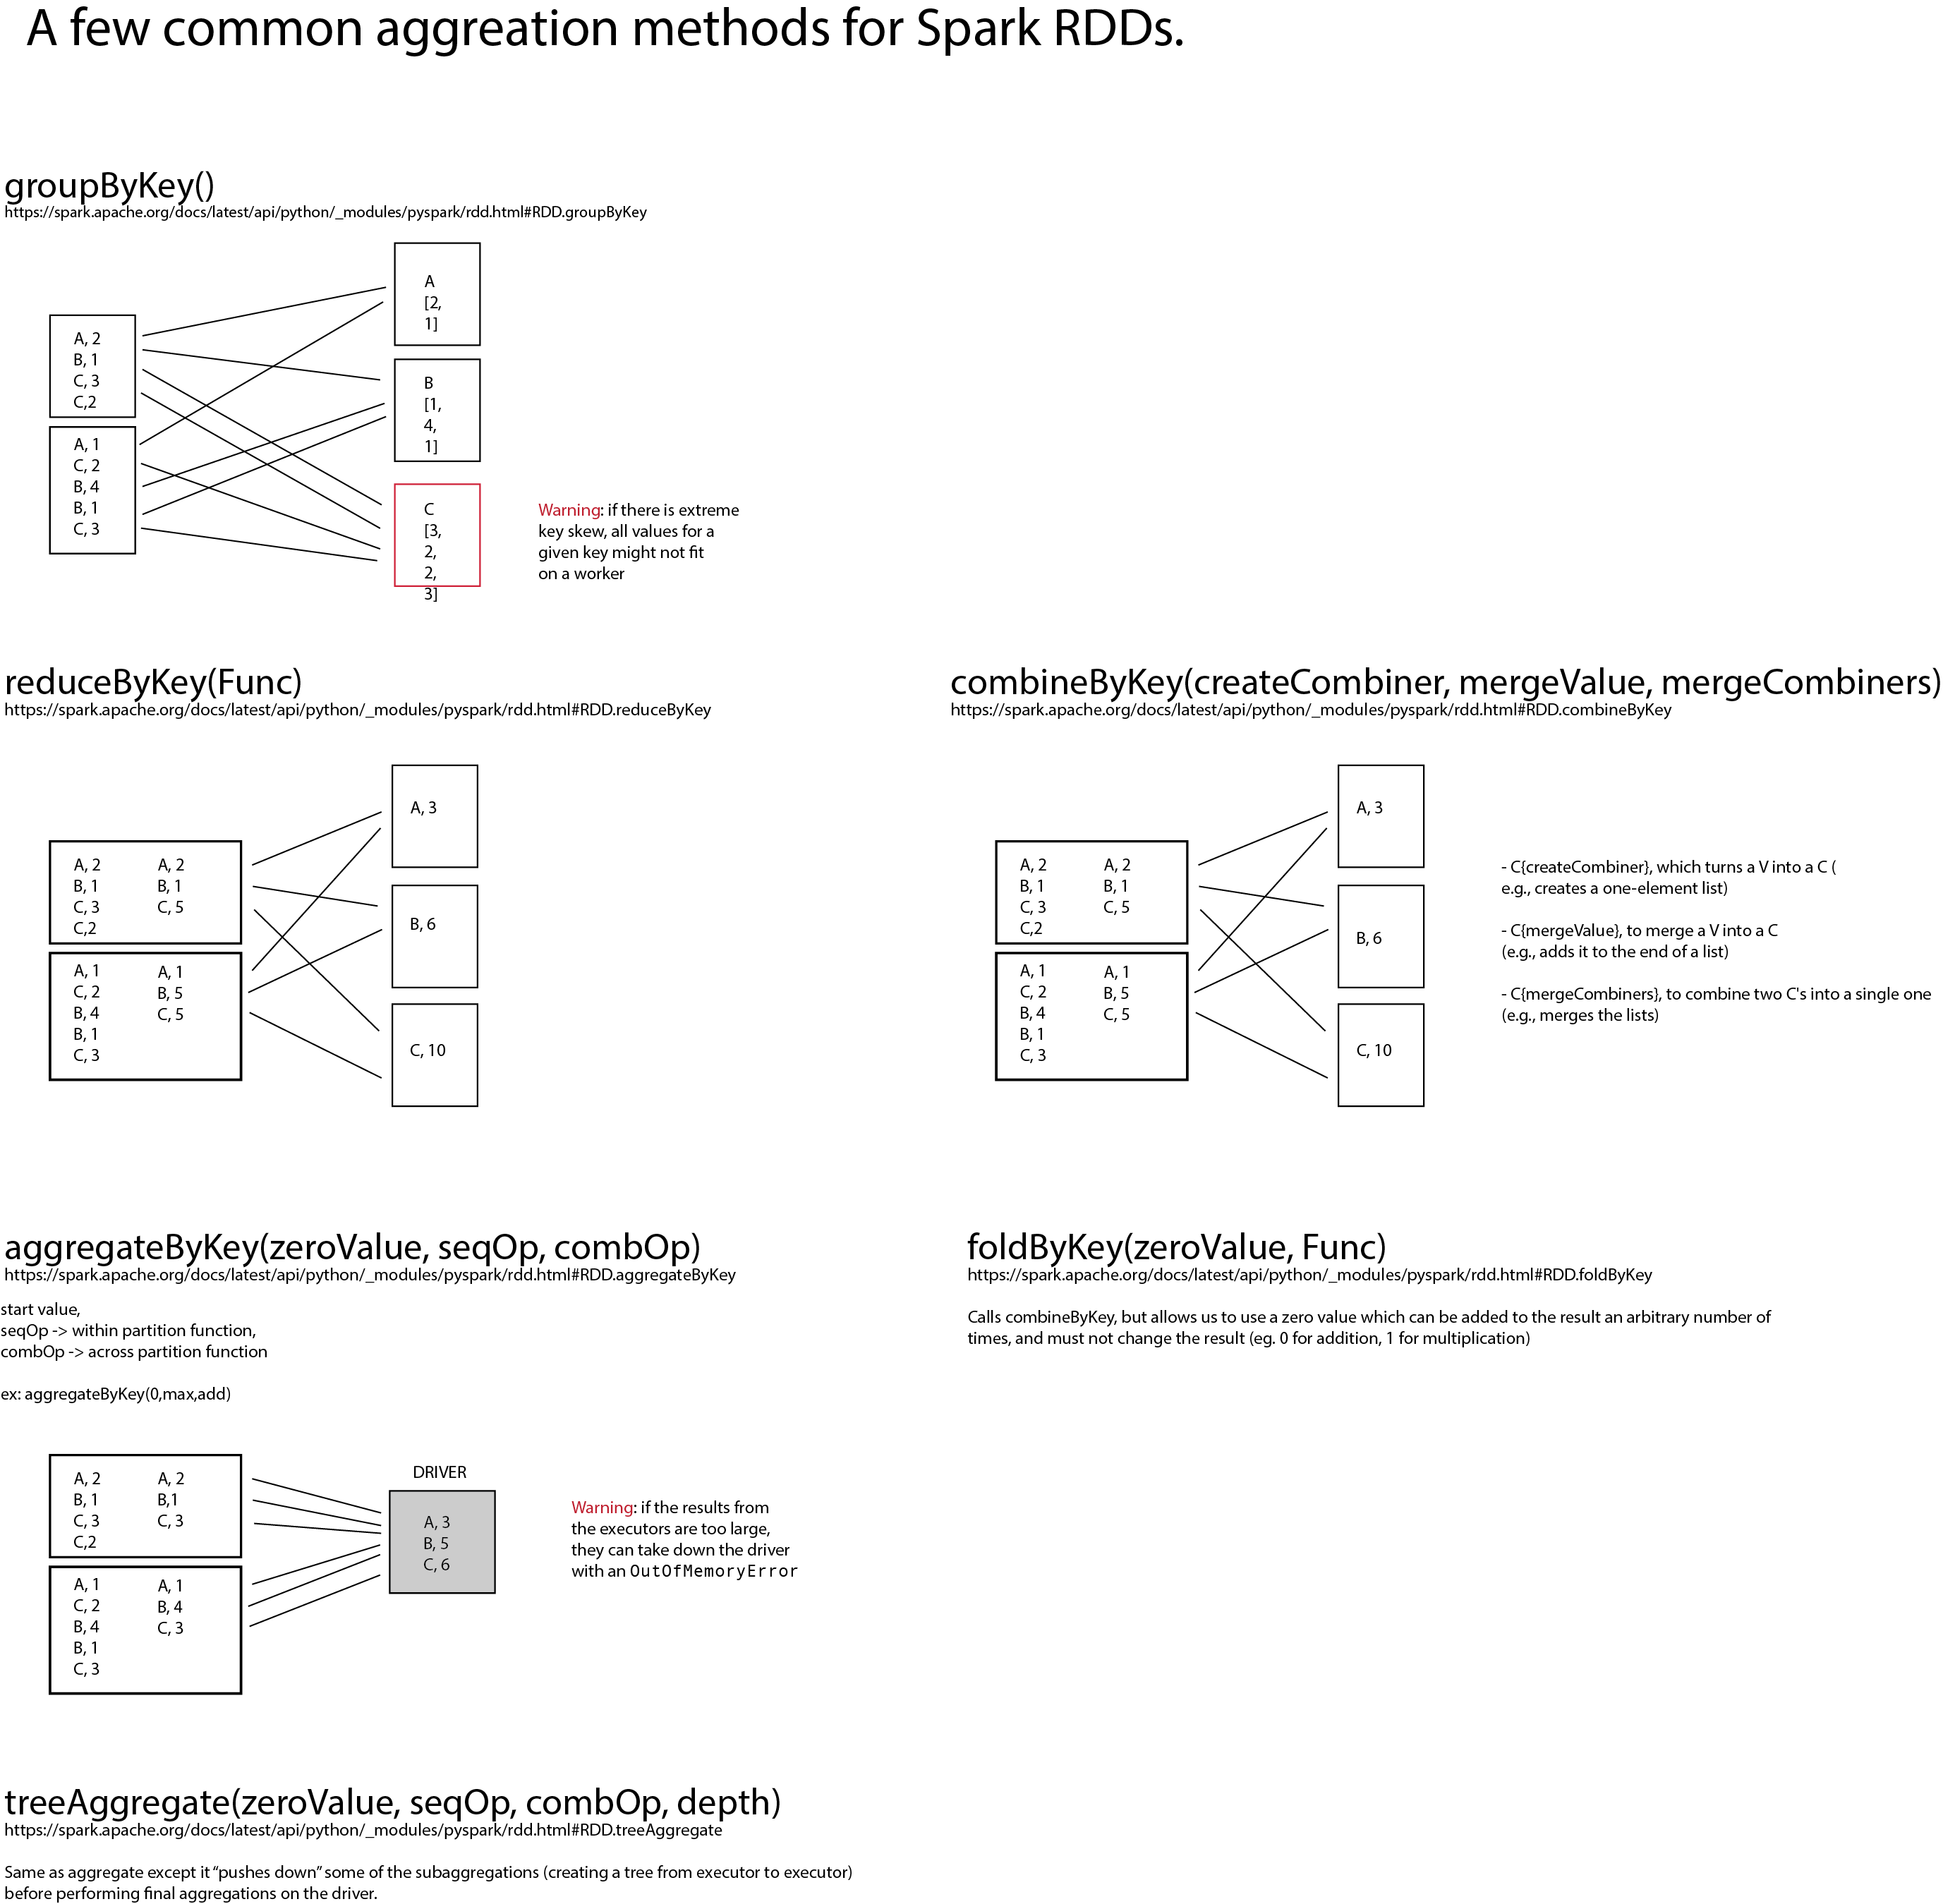

In [13]:
from IPython.display import Image 
Image(filename="aggregations.png")

What if we wanted to get a list of letter grades that each student recieved as well as their average?

In [89]:
def toLetterGrade(x):
    if x > 92.0:
        return "A"
    elif x > 82.0:
        return "B"
    elif x > 72.0:
        return "C"
    elif x > 65.0:
        return "D"
    else:
        return "F"

def getCounts(a,b):
    return (a[0] + b[0], a[1] + b[1], toLetterGrade(a[0])+toLetterGrade(b[0]))
    
studentAvgs = gradesRDD.map(lambda x: (x[0], (x[2], 1)))\
                       .reduceByKey(getCounts)\
                       .mapValues(lambda x: ((x[0]/x[1]),x[2]))\
                       .collect()

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 98.0 failed 1 times, most recent failure: Lost task 0.0 in stage 98.0 (TID 196, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 230, in main
    process()
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 225, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/opt/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 372, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/opt/spark/python/lib/pyspark.zip/pyspark/util.py", line 55, in wrapper
    return f(*args, **kwargs)
  File "/opt/anaconda/lib/python3.6/site-packages/pyspark-2.3.1-py3.6.egg/pyspark/rdd.py", line 1998, in <lambda>
    map_values_fn = lambda kv: (kv[0], f(kv[1]))
  File "<ipython-input-89-6c5a958d91f9>", line 16, in <lambda>
IndexError: tuple index out of range

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:298)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:438)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:421)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:252)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$class.foreach(Iterator.scala:893)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable$class.$plus$plus$eq(Growable.scala:59)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:104)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:48)
	at scala.collection.TraversableOnce$class.to(TraversableOnce.scala:310)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toBuffer(TraversableOnce.scala:302)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toArray(TraversableOnce.scala:289)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1$$anonfun$12.apply(RDD.scala:939)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1$$anonfun$12.apply(RDD.scala:939)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2074)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2074)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:345)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1602)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1590)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1589)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1589)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1823)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1772)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1761)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:642)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2034)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2055)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2074)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2099)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:939)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:938)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:162)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.GeneratedMethodAccessor56.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 230, in main
    process()
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 225, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/opt/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 372, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/opt/spark/python/lib/pyspark.zip/pyspark/util.py", line 55, in wrapper
    return f(*args, **kwargs)
  File "/opt/anaconda/lib/python3.6/site-packages/pyspark-2.3.1-py3.6.egg/pyspark/rdd.py", line 1998, in <lambda>
    map_values_fn = lambda kv: (kv[0], f(kv[1]))
  File "<ipython-input-89-6c5a958d91f9>", line 16, in <lambda>
IndexError: tuple index out of range

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:298)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:438)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:421)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:252)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$class.foreach(Iterator.scala:893)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable$class.$plus$plus$eq(Growable.scala:59)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:104)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:48)
	at scala.collection.TraversableOnce$class.to(TraversableOnce.scala:310)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toBuffer(TraversableOnce.scala:302)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toArray(TraversableOnce.scala:289)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1$$anonfun$12.apply(RDD.scala:939)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1$$anonfun$12.apply(RDD.scala:939)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2074)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2074)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:345)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	... 1 more


In [90]:
gradesRDD.map(lambda x: (x[0], (x[2], 1))).collect()

[('10001', (98, 1)),
 ('10001', (87, 1)),
 ('10002', (75, 1)),
 ('10002', (55, 1)),
 ('10002', (80, 1)),
 ('10003', (45, 1)),
 ('10003', (75, 1)),
 ('10004', (90, 1)),
 ('10005', (85, 1)),
 ('10005', (60, 1))]

In [91]:
gradesRDD.map(lambda x: (x[0], (x[2], 1)))\
                       .reduceByKey(getCounts)\
                       .collect()

[('10001', (185, 2, 'AB')),
 ('10004', (90, 1)),
 ('10002', (210, 3, 'AC')),
 ('10003', (120, 2, 'FC')),
 ('10005', (145, 2, 'BF'))]

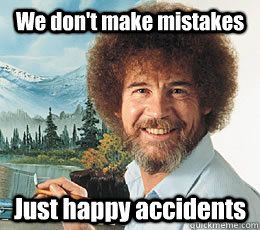

In [15]:
from IPython.display import Image 
Image(filename="Bob-Ross-3.jpg")

### foldByKey allows us to specify a zero value

In [92]:
gradesRDD.map(lambda x: (x[0], (x[2], 1))).foldByKey((0,0,""),getCounts).collect()

[('10001', (185, 2, 'AB')),
 ('10004', (90, 1, 'FB')),
 ('10002', (210, 3, 'AC')),
 ('10003', (120, 2, 'FC')),
 ('10005', (145, 2, 'BF'))]

### Can we solve this problem using a combineByKey which provides more granular control over the parameters
https://backtobazics.com/big-data/apache-spark-combinebykey-example/

In [71]:
def createCombiner(a):
    return a

def mergeValues(a,b):
    return (a[0] + b[0], a[1] + b[1], toLetterGrade(a[0])+toLetterGrade(b[0]));

def mergeCombiners(a,b):
    return (a[0] + b[0], a[1] + b[1], toLetterGrade(a[0])+toLetterGrade(b[0]))

studentAvgs = gradesRDD.map(lambda x: (x[0], (x[2], 1)))\
                       .combineByKey(createCombiner,mergeValues,mergeCombiners)\
                       .mapValues(lambda x: ((x[0]/x[1]),x[2]))

In [72]:
gradesRDD.map(lambda x: (x[0], (x[2], 1))).combineByKey(createCombiner,mergeValues,mergeCombiners).collect()

[('10001', (185, 2, 'AB')),
 ('10004', (90, 1)),
 ('10002', (210, 3, 'AC')),
 ('10003', (120, 2, 'FC')),
 ('10005', (145, 2, 'BF'))]

### aggragateByKey requires a null and start value as well as two different functions. One to aggregate within partitions, and one to aggregate across partitions

In [50]:
def seqOp(a,b):
    return(a[0] + b[0], a[1] + b[1], a[2]+toLetterGrade(b[2]))

def combOp(a,b):
    return (a+b);

In [73]:
gradesRDD.map(lambda x: (x[0], (x[2], 1, x[2])))\
         .aggregateByKey((0,0,""),seqOp,combOp)\
         .mapValues(lambda x: ((x[0]/x[1]),x[2]))\
         .collect()

[('10001', (92.5, 'AB')),
 ('10004', (90.0, 'B')),
 ('10002', (70.0, 'CFC')),
 ('10003', (60.0, 'FC')),
 ('10005', (72.5, 'BF'))]

In [52]:
letterAccum = sc.accumulator("===", StringAccumulatorParam())

gradesRDD.foreach(lambda x: letterAccum.add(toLetterGrade(x[2])))

In [53]:
print (letterAccum)

=== -> === -> A -> B -> C -> F -> C -> === -> F -> C -> B -> B -> F


# Joins

* join       
https://spark.apache.org/docs/latest/api/python/_modules/pyspark/rdd.html#RDD.join     
* leftOuterJoin   
https://spark.apache.org/docs/latest/api/python/_modules/pyspark/rdd.html#RDD.leftOuterJoin    
* rightOuterJoin   
https://spark.apache.org/docs/latest/api/python/_modules/pyspark/rdd.html#RDD.rightOuterJoin    
* fullOuterJoin   
https://spark.apache.org/docs/latest/api/python/_modules/pyspark/rdd.html#RDD.fullOuterJoin   
* cartesian   
https://spark.apache.org/docs/latest/api/python/_modules/pyspark/rdd.html#RDD.cartesian

In [ ]:
x = sc.parallelize([("a", 1), ("b", 4)])
y = sc.parallelize([("a", 2), ("c", 8)])
sorted(x.fullOuterJoin(y).collect())
#[('a', (1, 2)), ('b', (4, None)), ('c', (None, 8))]

In [ ]:
sorted(x.rightOuterJoin(y).collect())

In [ ]:
sorted(x.leftOuterJoin(y).collect())

Lets load some data for the code examples

In [ ]:
person = spark.createDataFrame([
    (0, "Bill Chambers", 0, [100]),
    (1, "Matei Zaharia", 1, [500, 250, 100]),
    (2, "Michael Armbrust", 1, [250, 100])])\
  .toDF("id", "name", "graduate_program", "spark_status")
graduateProgram = spark.createDataFrame([
    (0, "Masters", "School of Information", "UC Berkeley"),
    (2, "Masters", "EECS", "UC Berkeley"),
    (1, "Ph.D.", "EECS", "UC Berkeley")])\
  .toDF("id", "degree", "department", "school")
sparkStatus = spark.createDataFrame([
    (500, "Vice President"),
    (250, "PMC Member"),
    (100, "Contributor")])\
  .toDF("id", "status")

In [ ]:
# run as is
joinExpression = person["graduate_program"] == graduateProgram['id']

In [ ]:
# run as is
wrongJoinExpression = person["name"] == graduateProgram["school"]

In [ ]:
# run as is
person.join(graduateProgram, joinExpression).show()

In [ ]:
person.join(graduateProgram, wrongJoinExpression).show()

In [ ]:
# Spark perfoms an "inner" join by default. But we can specify this explicitly.
# Try different join types.
joinType = "outer"
joinType = "left_outer"
joinType = "right_outer"

In [ ]:
person.join(graduateProgram, joinExpression, joinType).show()

### Which keys do outer joins evaluate?

### A departure from traditional joins:

In [ ]:
gradProgram2 = graduateProgram.union(spark.createDataFrame([
    (0, "Masters", "Duplicated Row", "Duplicated School")]))
gradProgram2.createOrReplaceTempView("gradProgram2")

In [ ]:
# Think of left semi joins as filters on a DataFrame, as opposed to the function of a conventional join
joinType = "left_semi"
gradProgram2.join(person, joinExpression, joinType).show()

In [ ]:
gradProgram2.show()

In [ ]:
joinType = "left_anti"
gradProgram2.join(person, joinExpression, joinType).show()

### Natural Joins

__DANGER__: Natural joins make implicit guesses at the columns on which you would like to join. Why is this bad?

### Cross (Cartesian) Joins
Or, Cartesian products. Cross joinsare inner joins that do not specify a predicate. Cross joins will join every single row in the left DataFrame with every single row in the right DataFrame

In [ ]:
joinType = "cross"
graduateProgram.join(person, joinExpression, joinType).show()

In [ ]:
person.crossJoin(graduateProgram).show()

__DANGER__: How many rows would we end up with from a cross join if each table had 1000 rows?

# A Priori

(see WK5 slides)

# ---------------- END NOTEBOOK --------------------
## Future work: Clustering for anomaly detection   
http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.323.6870&rep=rep1&type=pdf   
https://proquest-safaribooksonline-com.libproxy.berkeley.edu/book/databases/9781491972946   
https://towardsdatascience.com/best-clustering-algorithms-for-anomaly-detection-d5b7412537c8   



## KDD Cup 1999 Data Set

For each connection, the data set contains information like the number of bytes sent, login attempts, TCP errors, and so on. Each connection is one line of CSV-formatted data set, containing 38 features, like this:

```
0,tcp,http,SF,215,45076,
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,
0.00,0.00,0.00,0.00,1.00,0.00,0.00,0,0,0.00,
0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal.
```

This connection, for example, was a TCP connection to an HTTP service—215 bytes were sent and 45,706 bytes were received. The user was logged in, and so on. Many features are counts, like num_file_creations in the 17th column.

Many features take on the value 0 or 1, indicating the presence or absence of a behavior, like su_attempted in the 15th column. They look like the one-hot encoded categorical features from Chapter 4, but are not grouped and related in the same way. Each is like a yes/no feature, and is therefore arguably a categorical feature. It is not always valid to translate categorical features as numbers and treat them as if they had an ordering. However, in the special case of a binary categorical feature, in most machine learning algorithms, mapping these to a numeric feature taking on values 0 and 1 will work well.

The rest are ratios like dst_host_srv_rerror_rate in the next-to-last column, and take on values from 0.0 to 1.0, inclusive.

Interestingly, a label is given in the last field. Most connections are labeled normal., but some have been identified as examples of various types of network attacks. These would be useful in learning to distinguish a known attack from a normal connection, but the problem here is anomaly detection and finding potentially new and unknown attacks. This label will be mostly set aside for our purposes.